In [1]:
## adapted from https://colab.research.google.com/drive/12zBvL0v0qZHbpSGXLLjHfQ0w6OZOVHaB#scrollTo=KhLt6VA3wvCB
# https://github.com/MilaNLProc/contextualized-topic-models#preprocessing

In [2]:
%%capture
!pip install contextualized-topic-models==1.8.1
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file, TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from gensim.corpora.dictionary import Dictionary
from gensim.models import ldamodel 
import os
import numpy as np
import pickle
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sashaqanderson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Let's read our data files and store the documents as lists of strings

In [4]:
# MODEL DATA CATALOG ABSTRACT DATA:
df = pd.read_csv('abstracts.csv')
df["title_text"] = df["Title"] + ' ' + df["Text"]
wp = WhiteSpacePreprocessing(df.title_text)
text_training_preprocessed, text_training_not_preprocessed, vocab_list = wp.preprocess()

### NOTE: Make sure that the lenghts of the two lists of documents are the same and the index of a not preprocessed document corresponds to the index of the same preprocessed document.

In [5]:
print(len(text_training_preprocessed) == len(text_training_not_preprocessed))

True


## Split into train/test

In [6]:
training_bow_documents = text_training_preprocessed[0:38]
training_contextual_document = text_training_not_preprocessed[0:38]

testing_bow_documents = text_training_preprocessed[38:]
testing_contextual_documents = text_training_not_preprocessed[38:]

## Create the training set

In [7]:
#uncomment to use regular BERT
# tp = TopicModelDataPreparation("bert-base-nli-mean-tokens")

# Using SPECTER from ALLENAI
tp = TopicModelDataPreparation("allenai-specter")

# if using SPECTER, add titles to training_contextual_document:


# TODO implement sciBERT:
# notes...
# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("gsarti/scibert-nli")
# model = AutoModel.from_pretrained("gsarti/scibert-nli")

# see https://www.kaggle.com/karlie777/covid-19-papers for an example

In [8]:
training_dataset = tp.create_training_set(training_contextual_document, training_bow_documents)

#### Let's check the vocabulary

In [9]:
tp.vocab[:10]

['ability',
 'absence',
 'acceleration',
 'accepted',
 'acceptor',
 'acceptors',
 'access',
 'accommodates',
 'account',
 'accounted']

In [10]:
#TODO check BERT input size
ctm = CombinedTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=200, num_topics=9)
ctm.fit(training_dataset) 

Epoch: [200/200]	 Seen Samples: [7600/7600]	Train Loss: 874.4493215460526	Time: 0:00:00.164193: : 200it [00:32,  6.11it/s]


## Get topics list

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/envs/USGS_1/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['physical', 'vegetation', 'model', 'aquatic', 'river'],
             1: ['fluid', 'conductivity', 'various', 'thick', 'blank'],
             2: ['circle', 'area', 'larger', 'methodology', 'map'],
             3: ['field', 'psd', 'environmental', 'stormwater', 'result'],
             4: ['fish', 'percent', 'warm', 'great', 'conditions'],
             5: ['hi', 'batch', 'ibm', 'inpt', 'transfer'],
             6: ['dimensional', 'solution', 'equations', 'feq', 'one'],
             7: ['coastal',
              'flooding',
              'hydrodynamic',
              'non',
              'morphological'],
             8: ['factor', 'magnitude', 'either', 'peak', 'earthquakes']})

## Look at a word cloud

In [13]:
%%capture
pip install matplotlib==3.1.3

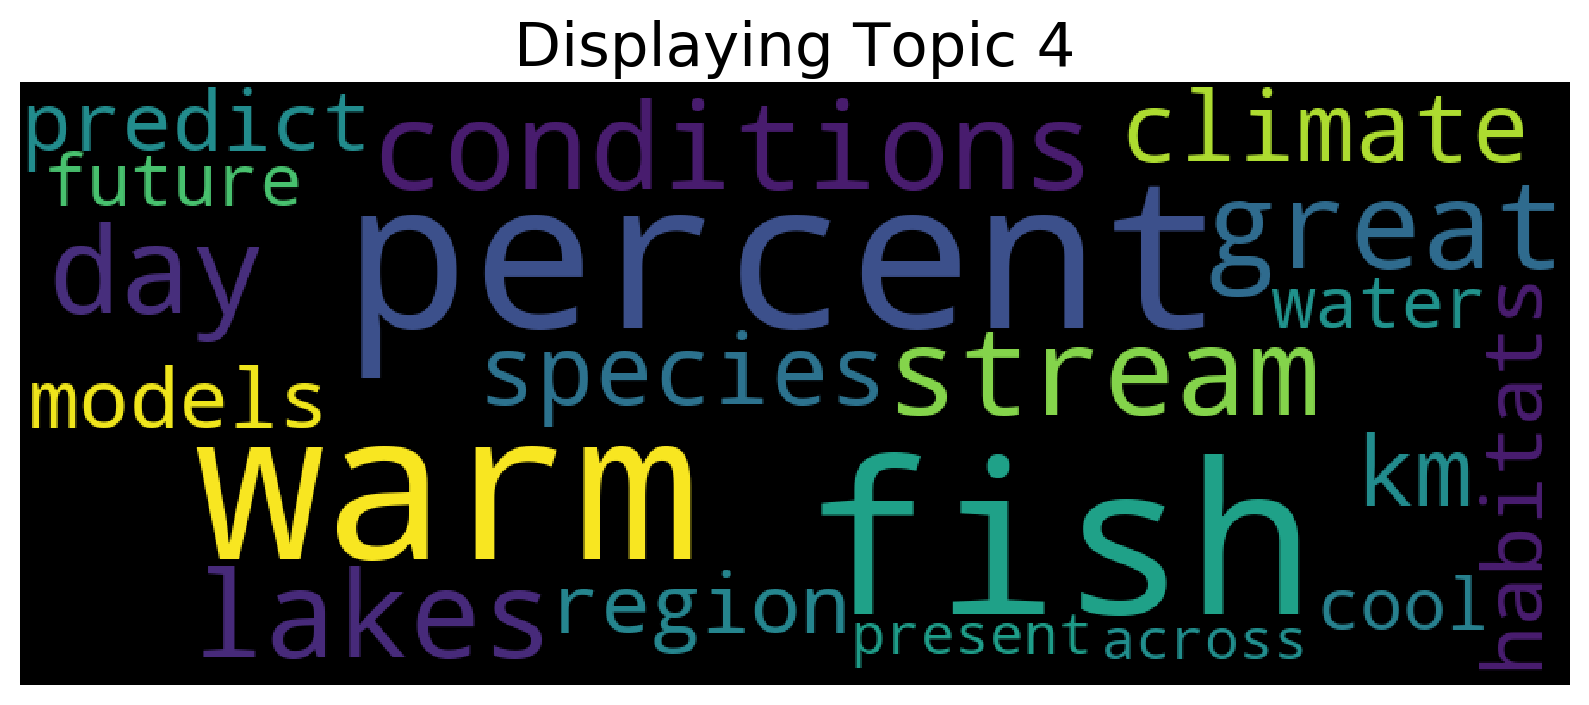

In [14]:
ctm.get_wordcloud(topic_id=4, n_words=20)

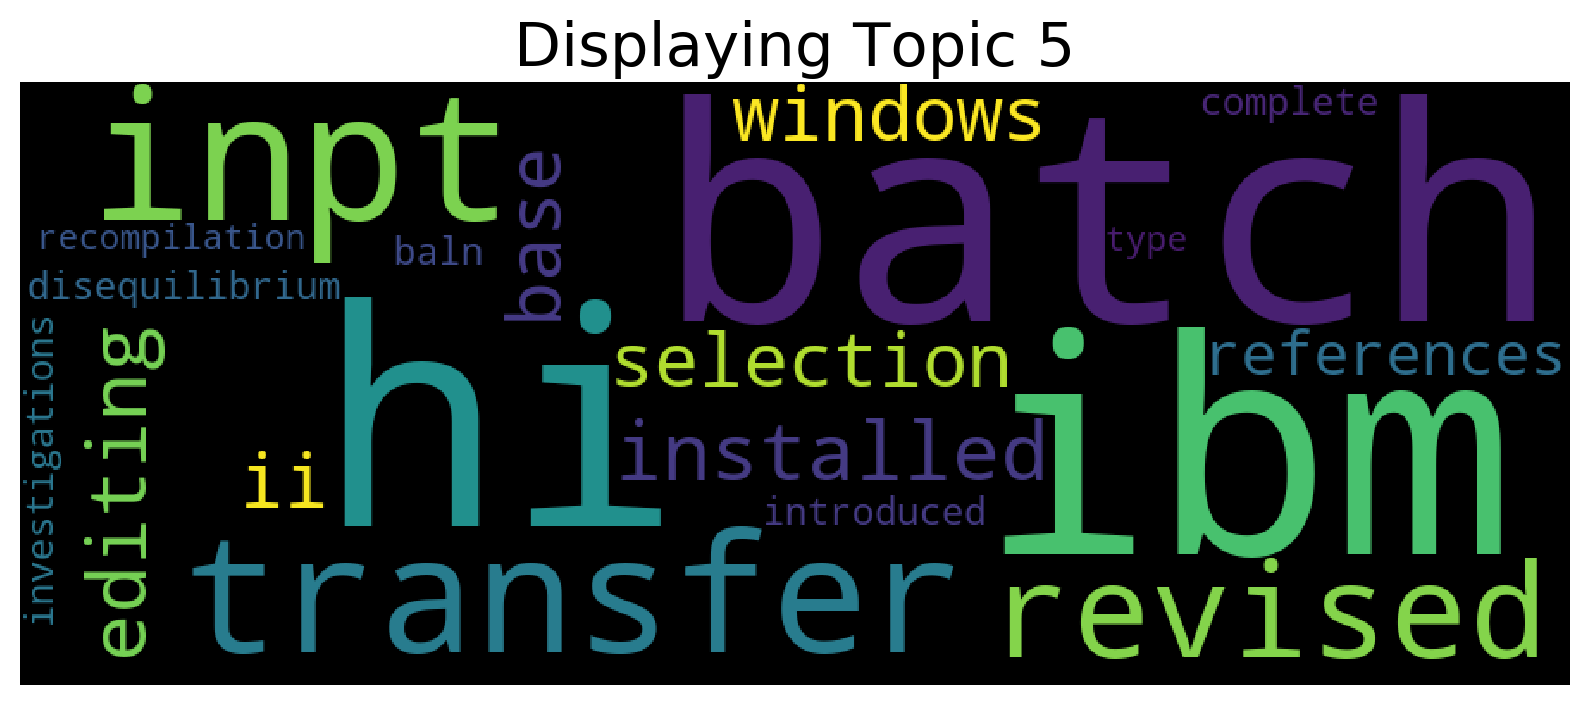

In [15]:
ctm.get_wordcloud(topic_id=5, n_words=20)

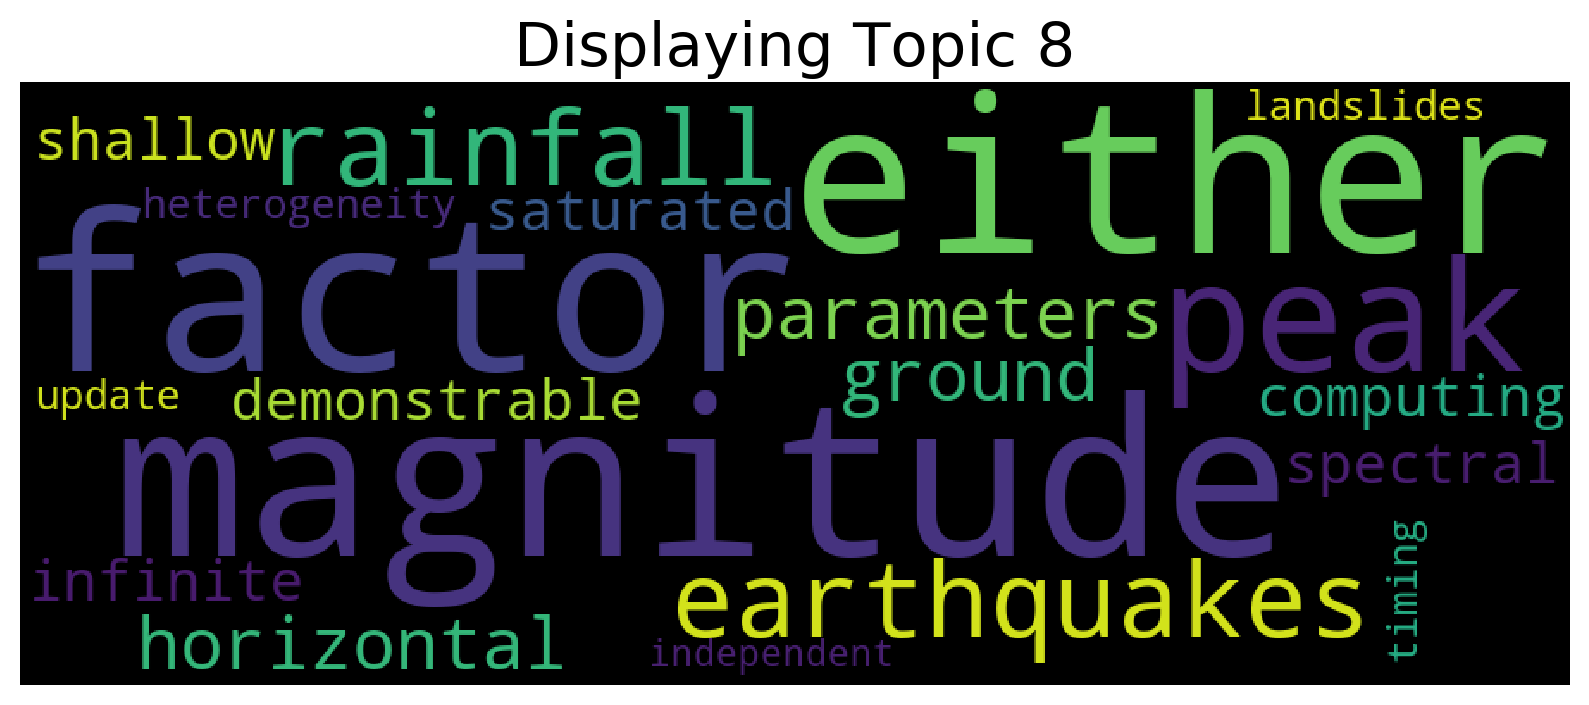

In [16]:
ctm.get_wordcloud(topic_id=8, n_words=20)

## Use the test set

In [17]:
testing_dataset = tp.create_test_set(testing_contextual_documents, testing_bow_documents) # create dataset for the testset
# print(testing_dataset[0])

In [18]:
predictions = ctm.get_doc_topic_distribution(testing_dataset, n_samples=1)

Sampling: [1/1]: : 1it [00:00, 10.06it/s]


In [19]:
#Select the test_document to view:
selected_doc = 0

print('probability for each topic', predictions[selected_doc])
print()
topic_index = np.argmax(predictions[selected_doc])
print('arg_max:', topic_index)
print()
print('original text:', testing_contextual_documents[selected_doc][0:350])
print()
print('topic_keywords:', ctm.get_topics(5)[topic_index])
# print(ctm.get_word_distribution_by_topic_id(topic_index)[0:20])

probability for each topic [0.03466056 0.04000273 0.35427281 0.09603395 0.16217896 0.09425984
 0.03954322 0.04752927 0.13151862]

arg_max: 2

original text: Scoops3D: software to analyze 3D slope stability throughout a digital landscape The computer program, Scoops3D, evaluates slope stability throughout a digital landscape represented by a digital elevation model (DEM). The program uses a three-dimensional (3D) method of columns approach to assess the stability of many (typically millions) potential l

topic_keywords: ['circle', 'area', 'larger', 'methodology', 'map']


In [20]:
pt = ctm.get_predicted_topics(testing_dataset, n_samples=1)
print(pt)

0it [00:00, ?it/s]

RuntimeError: DataLoader worker (pid 85151) is killed by signal: Unknown signal: 0. 

## Evaluate the model

## LDA

#### We are going to use gensim's LDA implementation and the preprocessed text to learn topics from the abstracts for comparison

In [ ]:
lda_text = list(map(lambda x : x.split(), training_bow_documents))

id2word = Dictionary(lda_text)
texts = lda_text
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=9, passes=10, alpha='auto', per_word_topics=True, iterations=200)

In [ ]:
lda_topics = []
for i in range(9):
    t = [w[0] for w in lda_model.show_topic(i)[0:10]]
    lda_topics.append(t)

In [ ]:
lda_topics[0]

## coherence score

In [ ]:
# #LDA topics
# npmi = CoherenceNPMI(texts=texts, topics=lda_topics)
# npmi.score()

In [ ]:
# #Combine topic score
# npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
# npmi.score()

## pyLDAvis

In [ ]:
!pip install pyLDAvis==3.3.1

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [ ]:
# https://github.com/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb 
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

In [ ]:
from gensim import models

hdp = models.hdpmodel.HdpModel(corpus, id2word, T=50)
vis_data = gensimvis.prepare(hdp, corpus, id2word)
pyLDAvis.display(vis_data)

In [ ]:
vis_data = gensimvis.prepare(ctm, corpus, id2word)
pyLDAvis.display(vis_data)
# AttributeError: 'CombinedTM' object has no attribute 'num_topics'

In [ ]:
# data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, R=30, lambda_step=0.01, sort_topics=True)
# # topic_term_dists: Matrix of topic-term probabilities
# # doc_topic_dists: Matrix of document-topic probabilities.
# # doc_lengths: The length of each document, i.e. the number of words in each document. The order of the numbers should be consistent with the ordering of the docs in doc_topic_dists.
# # vocab: List of all the words in the corpus used to train the model.
# # term_frequency: The count of each particular term over the entire corpus. The ordering of these counts should correspond with vocab and topic_term_dists.
# # R=30: The number of terms to display in the barcharts of the visualization. Default is 30. Recommended to be roughly between 10 and 50.
# pyLDAvis.display(data)